<a href="https://colab.research.google.com/github/brandon-setegn/data-mining-business-analytics/blob/master/Module_5_ML_PORTFOLIO_RETURN_RISK.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Part I: Stock Analysis and Machine Learning

**Background**

In this Analysis, we aim to study the relationship between a number of stock attributes (i.e. Factors) and their returns over a given horizon (e.g. 1 month). The dataset ("data_ml_sub.csv") comprises information on a subset of selected stocks, with a time range spanning November 1998 through March 2019. Some categories of the listed attributes include:

**valuation** (earning yields, accounting ratios);

**profitability and quality** (return on equity);

**momentum and technical analysis** (past returns, relative strength index);

**risk** (volatilities);

**estimates** (earnings-per-share);

**volume and liquidity** (share turnover).

We restrict the initial analysis to a subset of 100 stocks and the removal of outlier (unusually high or low) returns that may have happened due to external factors, mergers, aqcuisitions and so on. The sample is not perfectly rectangular: there are no missing points, but the number of firms and their attributes is not constant through time. This makes the computations in the backtest more tricky, but also more realistic.

The list below provides a brief description of the financials columns:

> **Advt_3M_Usd**: average daily volume in amount in USD over 3 months.


> **Div_Yld**: The dividend yield percentage is the amount of money a company pays shareholders for owning a share of its stock divided by its current stock price.

> **Eps**: Earnings per share is a company's net profit divided by the number of common shares it has outstanding.

> **Mkt_Cap_12M_Usd**: average market capitalization over 12 months in USD.

> **Mom_11M_Usd**: 	price momentum 12-1 months in USD.

> **Mom_Sharp_11M_Usd**: price momentum 12 - 1 months in USD divided by volatility.

> **Ni**: Net income.

> **Ocf**: operating cash flow is a measure of the amount of cash generated by a company's normal business operations.

> **Pb**: price to book ratio is a financial ratio and compares a company’s market price to its book value, essentially showing the value given by the market for each dollar of the company’s net worth.

> **Roa**: Return on asset.

> **Roe**: Return on equity.

> **Roc**: Return on capital.

> **Rev**: Revenue.

> **Ta**: Total Asset.

> **Vol1Y_Usd**: volatility of returns over one year.

> **Vol3Y_Usd**: volatility of returns over three year.

> **R1M_Usd**: 1 month forward returns of the stocks.


In [311]:
#let's import the libraries we are going to need
import os, csv
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import statsmodels.api as sm
import warnings
warnings.filterwarnings("ignore")

#%matplotlib notebook
%matplotlib inline

In [312]:
from google.colab import drive
drive.mount('/content/drive')

os.chdir('/content/drive/MyDrive/Development/machine_learning/fta724')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Key Analysis Parameters**

The following parameters are used to carry out the stock analysis and subsequent portfolio return/risk estimates. These include:

*   The original number of stocks (*n_stocks*) to do the analysis. The current list is purely based on the *stock_id* but ideally should be informed using a stock-selection philosophy. Would be interesting to change this value to 50, 150, 200 or 300 and observe the impact on overall analysis and quality of portfolio. The larger the selected number, the longer the analysis will take due to the required computation.
  
*   The lower and upper bound for the removal of return outliers. Currently, any return value greater than 10% or less than -10% is removed, due to being viewed as outliers that are perceived to have realized due to the external drivers (mergers and acquisitions, stock splits, market crashes, etc.) and not necessary due to the firm fundamentals.

*   The train-test split point in time. The current year of 2016 splits data to apptroximately 85% training and 15% testing sample or a (85%, 15%) split. In other words, data prior to 2016 is used for machine learning model training, and data including and after 2016 is used for machine learning model testing.Other options for a train-test split are (80%, 20%) or (90%, 10%).  

*   The rank percentile returns threshold. Stocks with predicted return in each month with a rank percentile greater than this number are considered high quality and hence included in the portfolio (refer t Part II of this notebook). Changing this value could impact the quality of the chosen portfolio and its risk-adjusted return estimate.


In [313]:
#######################################
#######################################
#######################################
#######################################
#######################################
#######################################

#############

# The number of stocks to start with.
# Change this value to 50, 150, 200 or 300 and observe the impact on overall analysis. Remember the larger the number, the longer the analysis will take.
n_stocks = 100

#############
#The return outlier threshold.
#Observation with a realized return of greater than (less than) upper bound (lower bound) will be dropped as outliers.
#Other possible lower/upper bounds can be -5/5 percent monthly retun.
#Change these bounds (e.g. lower bound of -5 or -3 and upper bound of 5 or 3) and observe the overall change to the portdolio return/risk.

lower_bound = -10
upper_bound = 10

#############
#The train-test split time point in time.
# The current year of 2016 splits data to apptroximately 85% training and 15% testing sample (85%, 15%). Other options are (80%, 20%) or (90%, 10%) splits.
year_pred = 2016

#############
#The rank percentile returns threshold.
#Stocks with predicted return rank percentile greater than this number are considered high quality and included in the portfolio (Refer to Part II of this notebook)
#Change this value to higher (e.g. 0.75, 0.8) or lower (0.6,0.55) and observe the overall change to the portdolio return/risk.
bound = 0.7

#######################################
#######################################
#######################################
#######################################
#######################################
#######################################

### EDA
Now let's read in data and carry out Exploratory Data Analysis (EDA).

In [314]:
#df = pd.read_csv('data_ml_sub.csv',index_col=False) #only run for full dataset

#we subset data
columns_to_keep = ['stock_id', 'date', 'Advt_3M_Usd','Div_Yld', 'Eps', 'Mkt_Cap_12M_Usd', 'Mom_11M_Usd', 'Mom_Sharp_11M_Usd', 'Ni', 'Ocf', 'Pb', 'Roa', 'Roc', 'Roe','Rev', 'Ta' ,'Vol1Y_Usd', 'Vol3Y_Usd', 'R1M_Usd']

df_raw = pd.read_csv('module_4_data_ml_sub.csv',index_col=False, usecols=columns_to_keep)

df = df_raw[(df_raw['stock_id'] <=100) & (lower_bound < df_raw['R1M_Usd'])  & (upper_bound > df_raw['R1M_Usd'])]



In [315]:
df.head()

,stock_id,date,Advt_3M_Usd,Div_Yld,Eps,Mkt_Cap_12M_Usd,Mom_11M_Usd,Mom_Sharp_11M_Usd,Ni,Ocf,Pb,Rev,Roa,Roc,Roe,Ta,Vol1Y_Usd,Vol3Y_Usd,R1M_Usd
0,1,2000-01-31,0.39,0.01,0.01,0.52,0.59,0.56,0.01,0.70,0.21,0.45,0.03,0.08,0.02,0.68,0.77,0.68,-0.036
1,1,2000-02-29,0.39,0.01,0.01,0.52,0.87,0.84,0.01,0.70,0.21,0.45,0.03,0.08,0.02,0.68,0.73,0.67,0.263
2,1,2000-03-31,0.37,0.20,0.07,0.51,0.55,0.55,0.06,0.74,0.15,0.46,0.07,0.10,0.06,0.69,0.67,0.66,0.031
3,1,2000-04-30,0.36,0.23,0.07,0.51,0.52,0.54,0.06,0.74,0.15,0.46,0.07,0.10,0.06,0.69,0.63,0.65,0.448
4,1,2000-05-31,0.42,0.17,0.07,0.52,0.46,0.47,0.06,0.74,0.15,0.46,0.07,0.10,0.06,0.69,0.54,0.67,-0.097


In [316]:
df.tail()

,stock_id,date,Advt_3M_Usd,Div_Yld,Eps,Mkt_Cap_12M_Usd,Mom_11M_Usd,Mom_Sharp_11M_Usd,Ni,Ocf,Pb,Rev,Roa,Roc,Roe,Ta,Vol1Y_Usd,Vol3Y_Usd,R1M_Usd
22600,100,2018-08-31,0.12,0.52,0.10,0.19,0.35,0.36,0.11,0.20,0.07,0.39,0.11,0.20,0.12,0.26,0.33,0.31,0.118
22601,100,2018-09-30,0.13,0.46,0.13,0.19,0.56,0.59,0.14,0.28,0.11,0.37,0.14,0.21,0.13,0.25,0.32,0.28,-0.068
22602,100,2018-10-31,0.13,0.46,0.13,0.19,0.67,0.70,0.14,0.28,0.11,0.37,0.14,0.21,0.13,0.25,0.37,0.31,0.083
22603,100,2018-11-30,0.14,0.45,0.13,0.19,0.71,0.72,0.14,0.28,0.11,0.37,0.14,0.21,0.13,0.25,0.40,0.30,-0.129
22604,100,2018-12-31,0.15,0.44,0.13,0.19,0.78,0.77,0.13,0.28,0.12,0.37,0.13,0.25,0.13,0.25,0.39,0.29,0.039


In [317]:
df.dtypes

stock_id               int64
date                  object
Advt_3M_Usd          float64
Div_Yld              float64
Eps                  float64
Mkt_Cap_12M_Usd      float64
Mom_11M_Usd          float64
Mom_Sharp_11M_Usd    float64
Ni                   float64
Ocf                  float64
Pb                   float64
Rev                  float64
Roa                  float64
Roc                  float64
Roe                  float64
Ta                   float64
Vol1Y_Usd            float64
Vol3Y_Usd            float64
R1M_Usd              float64
dtype: object

In [318]:
df['date'] = pd.to_datetime(df['date'], format = '%Y-%m-%d')
#df['stock_id'] = df['stock_id'].astype(str)

In [319]:
df.columns

Index(['stock_id', 'date', 'Advt_3M_Usd', 'Div_Yld', 'Eps', 'Mkt_Cap_12M_Usd',
       'Mom_11M_Usd', 'Mom_Sharp_11M_Usd', 'Ni', 'Ocf', 'Pb', 'Rev', 'Roa',
       'Roc', 'Roe', 'Ta', 'Vol1Y_Usd', 'Vol3Y_Usd', 'R1M_Usd'],
      dtype='object')

In [320]:
df.shape

(22605, 19)

In [321]:
df.describe()

,stock_id,Advt_3M_Usd,Div_Yld,Eps,Mkt_Cap_12M_Usd,Mom_11M_Usd,Mom_Sharp_11M_Usd,Ni,Ocf,Pb,Rev,Roa,Roc,Roe,Ta,Vol1Y_Usd,Vol3Y_Usd,R1M_Usd
count,22605.000000,22605.000000,22605.000000,22605.000000,22605.000000,22605.000000,22605.000000,22605.000000,22605.000000,22605.000000,22605.000000,22605.000000,22605.000000,22605.000000,22605.000000,22605.000000,22605.000000,22605.000000
mean,50.496262,0.505768,0.508557,0.518869,0.509438,0.506479,0.510032,0.497413,0.507641,0.485460,0.488173,0.489767,0.492551,0.490072,0.522628,0.483150,0.481412,0.012756
std,28.889621,0.290020,0.285713,0.291786,0.285172,0.284177,0.286992,0.291550,0.288608,0.286959,0.298733,0.288349,0.287902,0.282452,0.292955,0.284805,0.289464,0.129186
min,1.000000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,-0.875000
25%,25.000000,0.260000,0.260000,0.270000,0.260000,0.270000,0.260000,0.250000,0.260000,0.250000,0.210000,0.240000,0.230000,0.250000,0.270000,0.240000,0.230000,-0.041000
50%,51.000000,0.490000,0.520000,0.520000,0.510000,0.510000,0.510000,0.490000,0.500000,0.480000,0.480000,0.480000,0.500000,0.500000,0.530000,0.460000,0.450000,0.012000
75%,76.000000,0.770000,0.740000,0.770000,0.750000,0.750000,0.760000,0.740000,0.760000,0.740000,0.750000,0.740000,0.740000,0.730000,0.780000,0.730000,0.730000,0.063000
max,100.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,5.635000


**The profile of returns**

In [322]:
df.R1M_Usd.describe()

count    22605.000000
mean         0.012756
std          0.129186
min         -0.875000
25%         -0.041000
50%          0.012000
75%          0.063000
max          5.635000
Name: R1M_Usd, dtype: float64

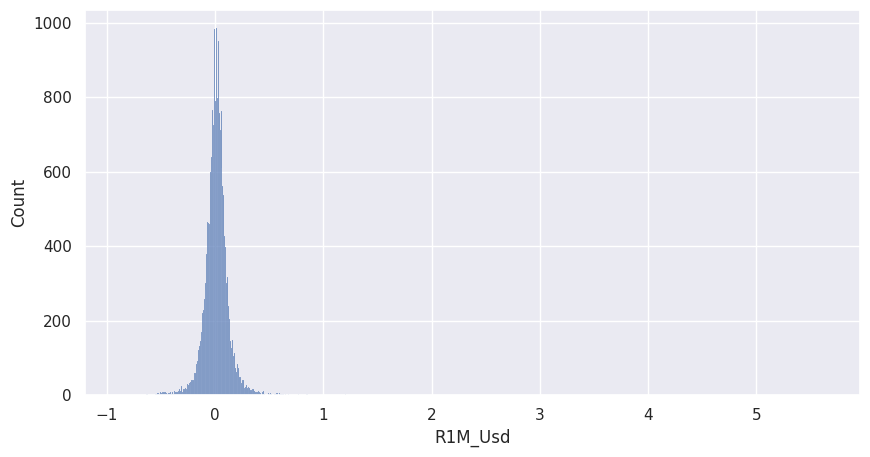

In [323]:
plt.figure(figsize=(10,5))
sns.set_style('darkgrid')
sns.set(font_scale=1)
sns.histplot(df.R1M_Usd);

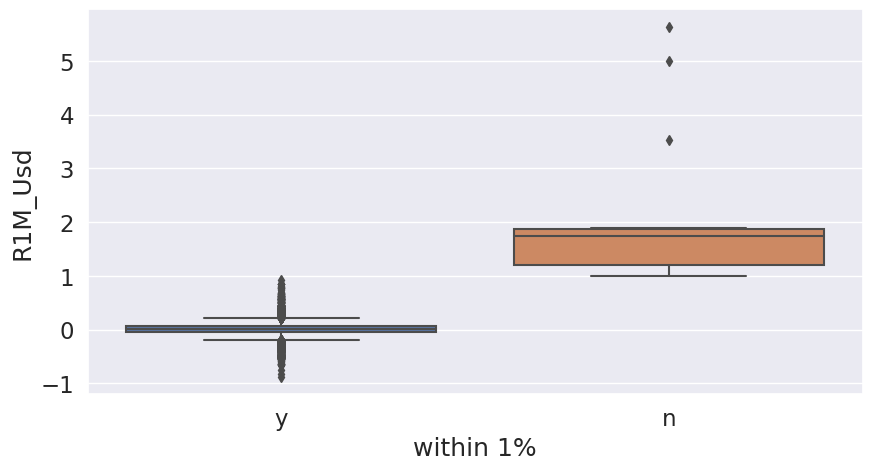

In [324]:
df_by_ret_mag = df[['date','stock_id','R1M_Usd']].copy()
df_by_ret_mag['within 1%'] = np.where(np.abs(df_by_ret_mag['R1M_Usd']) < 1, 'y', 'n')
plt.figure(figsize=(10,5))
sns.set_style('darkgrid')
sns.set(font_scale=1.5)
sns.boxplot(data=df_by_ret_mag,y='R1M_Usd',x='within 1%',);

**Top and bottom returns**

In [325]:
df.nlargest(5,['R1M_Usd'])

,stock_id,date,Advt_3M_Usd,Div_Yld,Eps,Mkt_Cap_12M_Usd,Mom_11M_Usd,Mom_Sharp_11M_Usd,Ni,Ocf,Pb,Rev,Roa,Roc,Roe,Ta,Vol1Y_Usd,Vol3Y_Usd,R1M_Usd
11364,51,2006-09-30,0.82,0.31,0.04,0.71,0.75,0.52,0.02,0.03,0.52,0.47,0.04,0.03,0.04,0.59,0.96,0.95,5.635
9706,44,2000-12-31,0.21,0.63,0.50,0.42,0.02,0.02,0.49,0.57,0.50,0.58,0.51,0.67,0.95,0.21,0.93,0.87,5.000
19225,86,2001-01-31,0.05,0.22,0.06,0.04,0.01,0.01,0.07,0.06,0.18,0.01,0.02,0.01,0.02,0.02,0.97,0.99,3.526
18869,84,2009-03-31,0.22,0.96,0.04,0.13,0.04,0.44,0.12,0.36,1.00,0.49,0.13,0.39,0.05,0.56,0.99,0.99,1.886
15017,67,2009-03-31,0.09,0.99,0.02,0.04,0.01,0.08,0.06,0.38,0.15,0.80,0.04,0.28,0.02,0.46,0.97,0.95,1.851


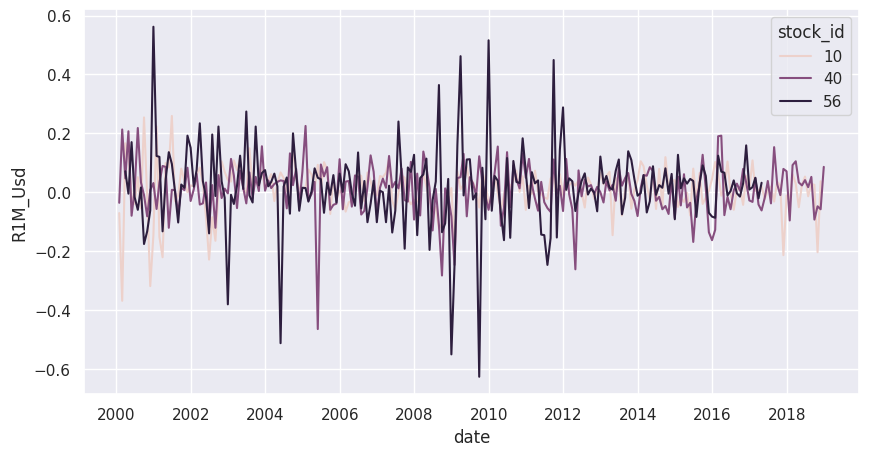

In [326]:
stocks_list = [10,40,56]
df_max_ret = df[df['stock_id'].isin(stocks_list)]
plt.figure(figsize=(10,5))
sns.set_style('darkgrid')
sns.set(font_scale=1)
sns.lineplot(x=df_max_ret.date,y=df_max_ret.R1M_Usd,hue=df_max_ret.stock_id);

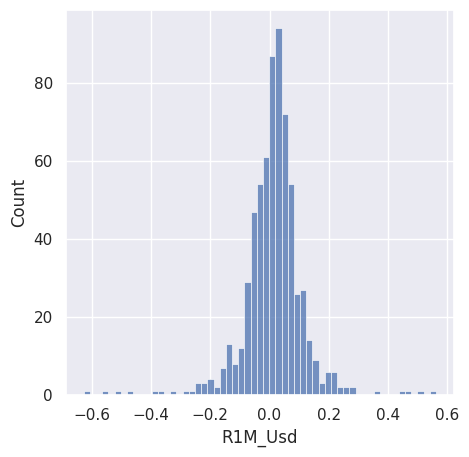

In [327]:
plt.figure(figsize=(5,5))
sns.set_style('darkgrid')
sns.set(font_scale=1)
sns.histplot(df_max_ret.R1M_Usd);

In [328]:
df.nsmallest(5,['R1M_Usd'])

,stock_id,date,Advt_3M_Usd,Div_Yld,Eps,Mkt_Cap_12M_Usd,Mom_11M_Usd,Mom_Sharp_11M_Usd,Ni,Ocf,Pb,Rev,Roa,Roc,Roe,Ta,Vol1Y_Usd,Vol3Y_Usd,R1M_Usd
9701,44,2000-07-31,0.61,0.45,0.92,0.55,0.79,0.76,0.63,0.62,0.47,0.67,0.54,0.59,0.78,0.57,0.61,0.73,-0.875
1692,8,2008-06-30,0.65,0.59,0.97,0.72,0.78,0.82,0.77,0.75,0.63,0.61,0.77,0.71,0.62,0.60,0.09,0.09,-0.833
5774,26,2008-05-31,0.26,0.02,0.01,0.40,0.01,0.02,0.01,0.60,0.01,0.25,0.03,0.02,0.03,0.76,1.00,1.00,-0.747
13712,61,2014-06-30,0.35,0.24,0.18,0.40,0.57,0.43,0.32,0.31,0.83,0.30,0.45,0.60,0.55,0.27,0.73,0.49,-0.664
17433,78,2002-03-31,0.98,0.10,0.01,0.86,0.10,0.17,0.01,0.68,0.17,0.52,0.01,0.02,0.01,0.80,0.94,0.96,-0.657


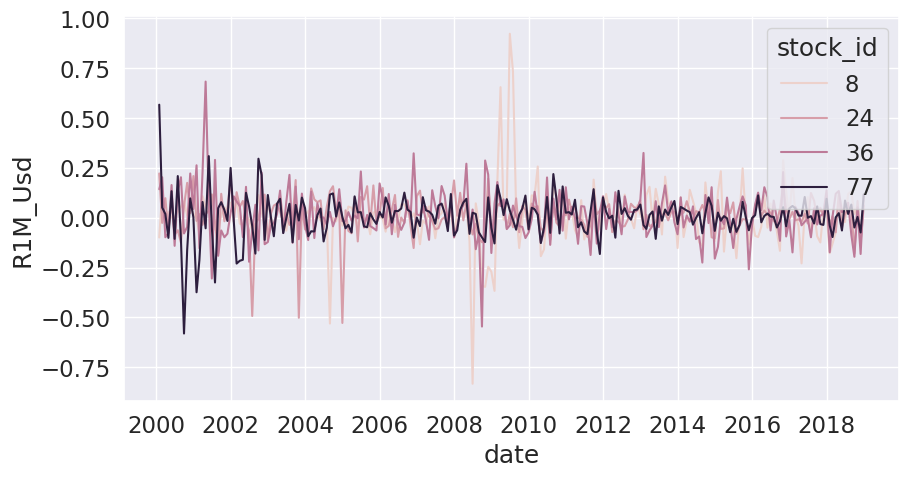

In [329]:
stocks_list = [8, 24, 36, 77]
df_min_ret = df[df['stock_id'].isin(stocks_list)]
plt.figure(figsize=(10,5))
sns.set_style('darkgrid')
sns.set(font_scale=1.5)
g=sns.lineplot(x=df_min_ret.date,y=df_min_ret.R1M_Usd,hue=df_min_ret.stock_id);

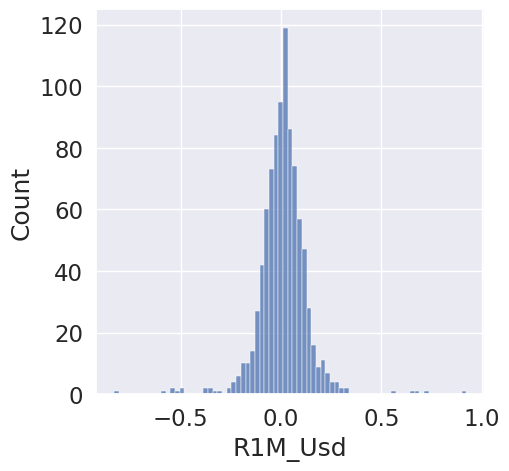

In [330]:
plt.figure(figsize=(5,5))
sns.set_style('darkgrid')
sns.set(font_scale=1.5)
sns.histplot(df_min_ret.R1M_Usd);

It is plausible to examine serial autocorrelation in returns, i.e. whether returns on previous day(s) have an impact on next days.

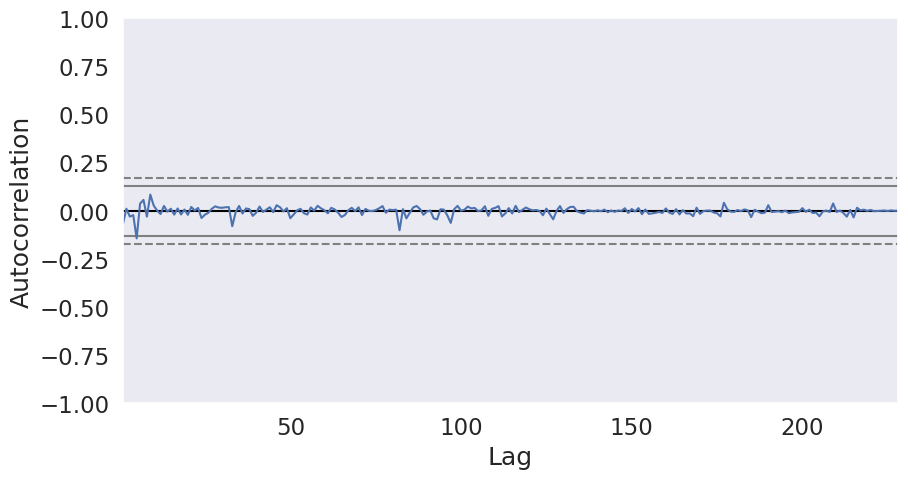

In [331]:
df_acf =  df[df['stock_id'] == 44]
plt.figure(figsize=(10,5))
pd.plotting.autocorrelation_plot(df_acf['R1M_Usd']);

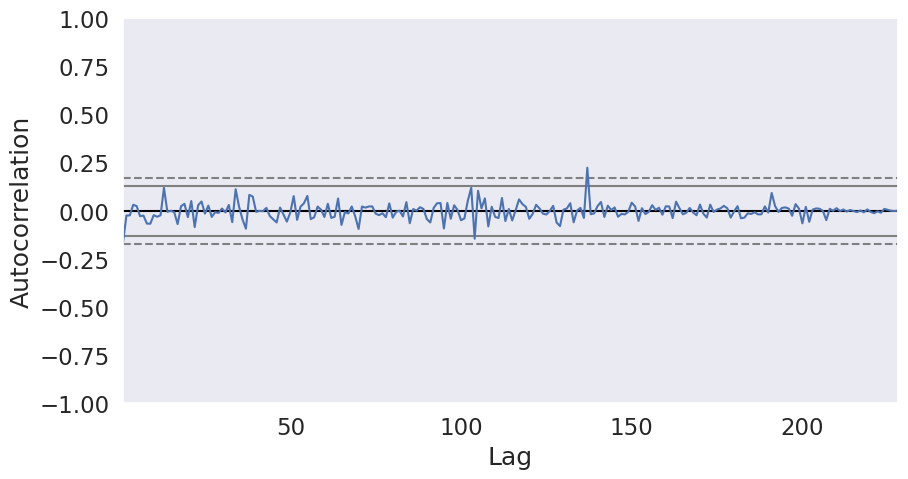

In [332]:
df_acf =  df[df['stock_id'] == 76]
plt.figure(figsize=(10,5))
pd.plotting.autocorrelation_plot(df_acf['R1M_Usd']);

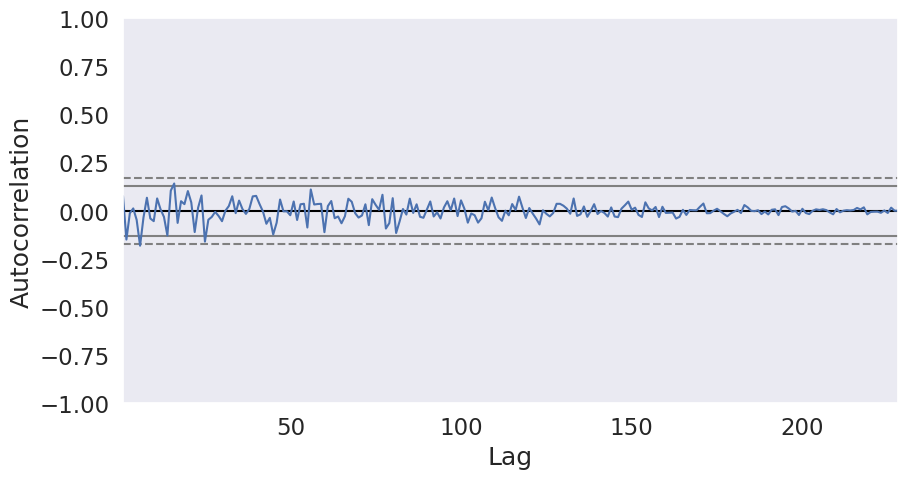

In [333]:
randid= df.groupby('stock_id').max().sample().index[0]
df_acf =  df[df['stock_id'] == randid ]
plt.figure(figsize=(10,5))
pd.plotting.autocorrelation_plot(df_acf['R1M_Usd']);

**The profiles of other factors**

Below, we show a box-plot that illustrates the distribution of correlations between features and the one month ahead return. The correlations are computed on a date-by-date basis, over the whole cross-section of stocks.

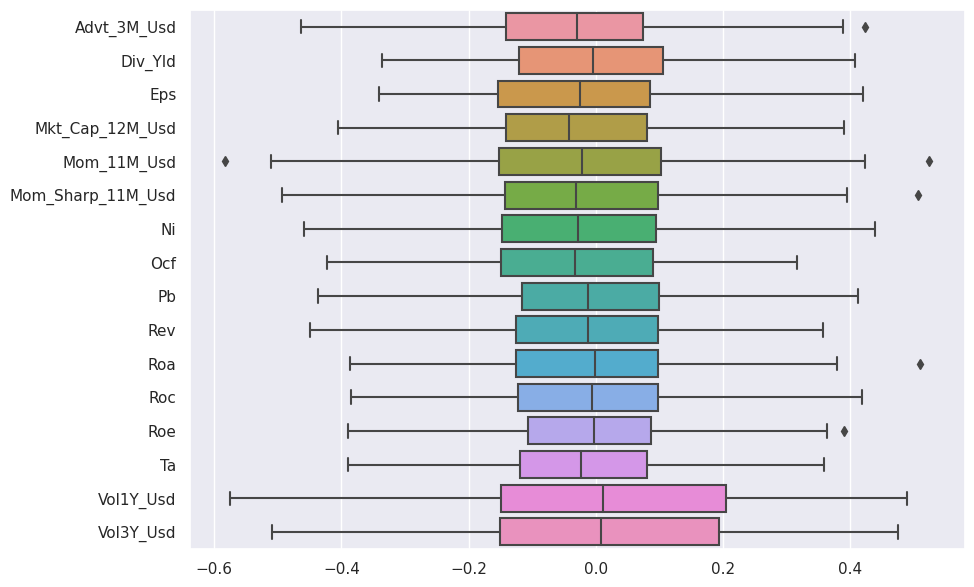

In [334]:
df_corr_by_date = df.drop(['stock_id','R1M_Usd'], axis=1).groupby('date').corrwith(df['R1M_Usd'])
plt.figure(figsize=(10,7))
sns.set_style('darkgrid')
sns.set(font_scale=1)
sns.boxplot(data=df_corr_by_date,orient='h');

We may also plot smoothed conditional average when the dependent variable is the one month ahead return and explanatory variables are market cap or volatility.

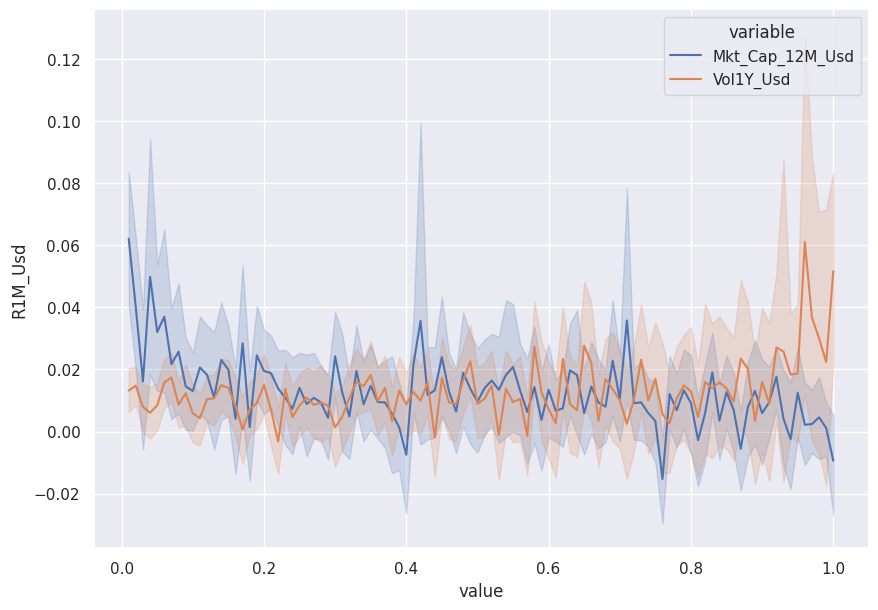

In [335]:
unpivoted_df = pd.melt(df[['R1M_Usd','Mkt_Cap_12M_Usd','Vol1Y_Usd']], id_vars='R1M_Usd') # selecting and putting in vector
plt.figure(figsize=(10,7))
sns.lineplot(data = unpivoted_df, y='R1M_Usd', x='value', hue='variable'); # Plot from seaborn

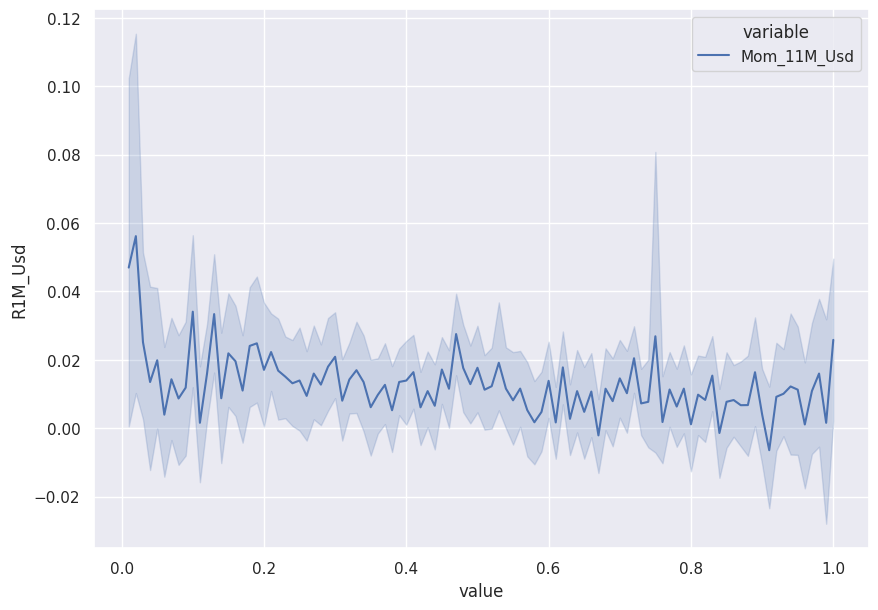

In [336]:
unpivoted_df2 = pd.melt(df[['R1M_Usd','Mom_11M_Usd']], id_vars='R1M_Usd') # selecting and putting in vector
plt.figure(figsize=(10,7))
sns.lineplot(data = unpivoted_df2, y='R1M_Usd', x='value', hue='variable'); # Plot from seaborn

In the code below, we investigate the size anomaly, i.e. the firms with below median market cap should earn higher returns on average (this happens most of the time as indicated by taller orange bars).

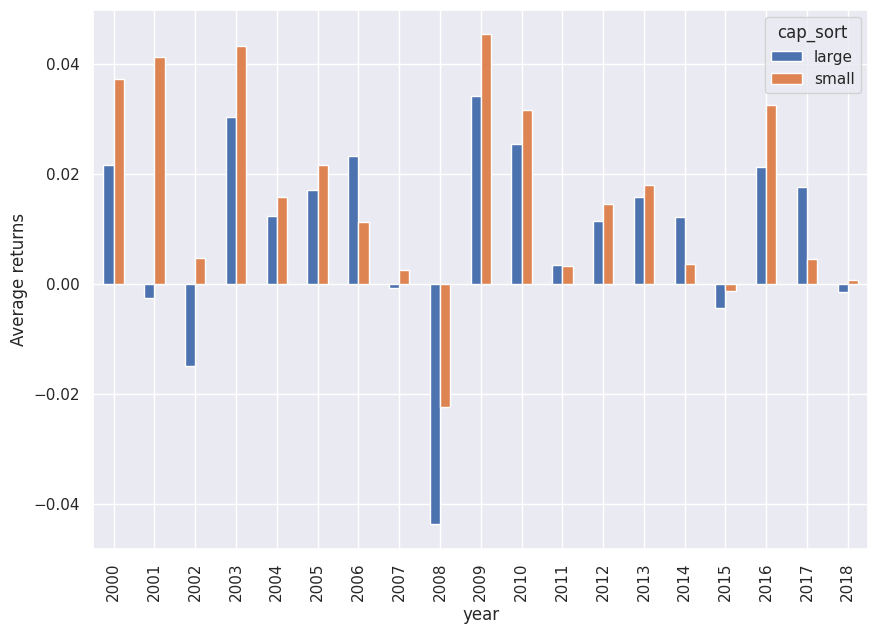

In [337]:
df_ret_median=[]          #creating empty placeholder for temporary dataframe
df_ret=[]
df_ret_median=df[['date','Mkt_Cap_12M_Usd']].groupby(['date']).median().reset_index() # computing median
df_ret_median.rename(columns = {'Mkt_Cap_12M_Usd': 'cap_median'}, inplace = True) # renaming for clarity
df_ret = pd.merge(df[["date",'Mkt_Cap_12M_Usd','R1M_Usd']],df_ret_median,how='left', on=['date'])
df_ret=df_ret.groupby([pd.to_datetime(df_ret['date']).dt.year,np.where(df_ret['Mkt_Cap_12M_Usd'] > df_ret['cap_median'], 'large', 'small')])['R1M_Usd'].mean().reset_index() # groupby and defining "year" and cap logic
df_ret.rename(columns = {'level_1': 'cap_sort'}, inplace = True)
df_ret.pivot(index='date',columns='cap_sort',values='R1M_Usd').plot.bar(figsize=(10,7))
plt.ylabel('Average returns')
plt.xlabel('year')
df_ret_median=[]          #removing the temp dataframe to keep it light!
df_ret=[]                 #removing the temp dataframe to keep it light!

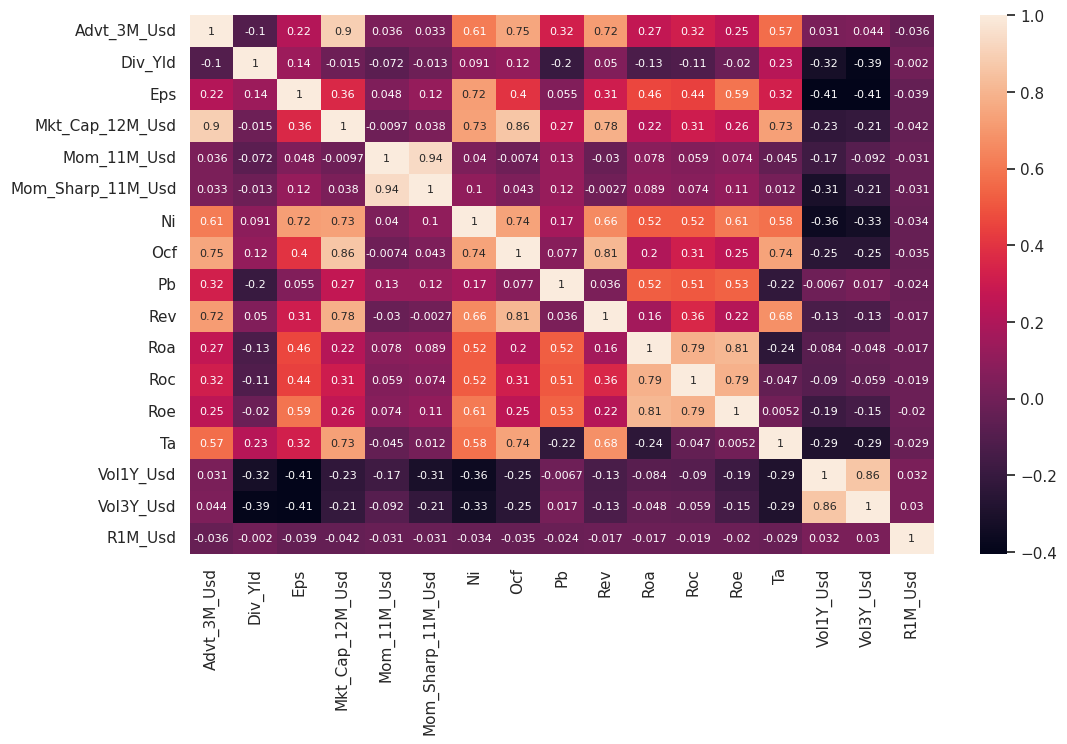

In [338]:
plt.figure(figsize=(12,7))
sns.heatmap(df.loc[:, df.columns!='stock_id'].corr(),annot=True,annot_kws={"size":8});

In [339]:
df_regplot_sub = df[['date','Vol1Y_Usd','Mkt_Cap_12M_Usd','Mom_11M_Usd','Eps','R1M_Usd']].groupby('date').mean()
plt.figure(figsize=(10,8))
sns.set_style('darkgrid')
sns.set(font_scale=1.5)
#sns.regplot(data=df_regplot_sub,x='Vol1Y_Usd',y='R1M_Usd');
fig=px.scatter(data_frame=df_regplot_sub,x='Vol1Y_Usd',y='R1M_Usd',trendline='ols');
fig.show();
#result=px.get_trendline_results(fig)
#result.px_fit_results.iloc[0].summary()

<Figure size 1000x800 with 0 Axes>

In [340]:
sns.set_style('darkgrid')
sns.set(font_scale=1.5)
px.scatter(data_frame=df_regplot_sub,x='Mkt_Cap_12M_Usd',y='R1M_Usd',trendline='ols')

In [341]:
sns.set_style('darkgrid')
sns.set(font_scale=1.5)
px.scatter(data_frame=df_regplot_sub,x='Mom_11M_Usd',y='R1M_Usd',trendline='ols')

In [342]:
sns.set_style('darkgrid')
sns.set(font_scale=1.5)
px.scatter(data_frame=df_regplot_sub,x='Eps',y='R1M_Usd',trendline='ols')

In [343]:
sns.set_style('darkgrid')
sns.set(font_scale=1.5)
px.scatter(data_frame=df_regplot_sub,x='Vol1Y_Usd',y='Mom_11M_Usd',trendline='ols')

**Machine Learning**

Let's develop some models. First split data into two portions, training and test samples. Here, we use data prior to 2016 as training data which is approximately 85% of total sample. We also drop 12 month return column and seek to predict next month's returns only.

In [344]:
df['year'] = pd.DatetimeIndex(df['date']).year
df['month'] = pd.DatetimeIndex(df['date']).month
df['week'] =  pd.DatetimeIndex(df['date']).week
df['day'] = pd.DatetimeIndex(df['date']).day
df

,stock_id,date,Advt_3M_Usd,Div_Yld,Eps,Mkt_Cap_12M_Usd,Mom_11M_Usd,Mom_Sharp_11M_Usd,Ni,Ocf,...,Roc,Roe,Ta,Vol1Y_Usd,Vol3Y_Usd,R1M_Usd,year,month,week,day
0,1,2000-01-31,0.39,0.01,0.01,0.52,0.59,0.56,0.01,0.70,...,0.08,0.02,0.68,0.77,0.68,-0.036,2000,1,5,31
1,1,2000-02-29,0.39,0.01,0.01,0.52,0.87,0.84,0.01,0.70,...,0.08,0.02,0.68,0.73,0.67,0.263,2000,2,9,29
2,1,2000-03-31,0.37,0.20,0.07,0.51,0.55,0.55,0.06,0.74,...,0.10,0.06,0.69,0.67,0.66,0.031,2000,3,13,31
3,1,2000-04-30,0.36,0.23,0.07,0.51,0.52,0.54,0.06,0.74,...,0.10,0.06,0.69,0.63,0.65,0.448,2000,4,17,30
4,1,2000-05-31,0.42,0.17,0.07,0.52,0.46,0.47,0.06,0.74,...,0.10,0.06,0.69,0.54,0.67,-0.097,2000,5,22,31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22600,100,2018-08-31,0.12,0.52,0.10,0.19,0.35,0.36,0.11,0.20,...,0.20,0.12,0.26,0.33,0.31,0.118,2018,8,35,31
22601,100,2018-09-30,0.13,0.46,0.13,0.19,0.56,0.59,0.14,0.28,...,0.21,0.13,0.25,0.32,0.28,-0.068,2018,9,39,30
22602,100,2018-10-31,0.13,0.46,0.13,0.19,0.67,0.70,0.14,0.28,...,0.21,0.13,0.25,0.37,0.31,0.083,2018,10,44,31
22603,100,2018-11-30,0.14,0.45,0.13,0.19,0.71,0.72,0.14,0.28,...,0.21,0.13,0.25,0.40,0.30,-0.129,2018,11,48,30


In [345]:
df_train = df[df['year'] < year_pred].drop(['stock_id','date','week','day','month','year'],axis=1)
df_test = df[df['year'] >= year_pred].drop(['stock_id','date','week','day','month','year'],axis=1)
100*np.round(df_train.shape[0]/df.shape[0],2)

84.0

In [346]:
df_test

,Advt_3M_Usd,Div_Yld,Eps,Mkt_Cap_12M_Usd,Mom_11M_Usd,Mom_Sharp_11M_Usd,Ni,Ocf,Pb,Rev,Roa,Roc,Roe,Ta,Vol1Y_Usd,Vol3Y_Usd,R1M_Usd
192,0.94,0.26,0.90,0.85,0.27,0.32,0.84,0.82,0.45,0.62,0.63,0.04,0.46,0.77,0.76,0.78,-0.028
193,0.95,0.26,0.90,0.85,0.24,0.29,0.84,0.82,0.45,0.62,0.63,0.04,0.46,0.77,0.82,0.82,0.168
194,0.95,0.26,0.06,0.85,0.24,0.32,0.05,0.81,0.48,0.61,0.11,0.04,0.12,0.78,0.82,0.82,0.183
195,0.95,0.26,0.06,0.85,0.23,0.28,0.05,0.81,0.48,0.61,0.11,0.04,0.12,0.78,0.83,0.82,-0.035
196,0.94,0.26,0.06,0.85,0.75,0.66,0.05,0.81,0.48,0.61,0.11,0.04,0.12,0.78,0.82,0.81,-0.064
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22600,0.12,0.52,0.10,0.19,0.35,0.36,0.11,0.20,0.07,0.39,0.11,0.20,0.12,0.26,0.33,0.31,0.118
22601,0.13,0.46,0.13,0.19,0.56,0.59,0.14,0.28,0.11,0.37,0.14,0.21,0.13,0.25,0.32,0.28,-0.068
22602,0.13,0.46,0.13,0.19,0.67,0.70,0.14,0.28,0.11,0.37,0.14,0.21,0.13,0.25,0.37,0.31,0.083
22603,0.14,0.45,0.13,0.19,0.71,0.72,0.14,0.28,0.11,0.37,0.14,0.21,0.13,0.25,0.40,0.30,-0.129


In [347]:
X_train = df_train.drop('R1M_Usd',axis=1)
y_train = df_train['R1M_Usd']
X_test = df_test.drop('R1M_Usd',axis=1)
y_test = df_test['R1M_Usd']

In [348]:
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn import tree
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, r2_score
from sklearn.metrics import *
from sklearn.ensemble import StackingRegressor

In [349]:
def eval_metrics(model,sample,y_true,y_pred):
  rmse = np.round(mean_squared_error(y_true,y_pred),3)
  mae = np.round(mean_absolute_error(y_true,y_pred),3)
  max_e = np.round(max_error(y_true,y_pred),3)
  max_abs_e = np.round(np.max(np.abs((y_true-y_pred))),3)
  rsq = np.round(r2_score(y_true,y_pred),3)
  metrics_df = {'model':[model],'sample':[sample],'rmse':[rmse],'mae':[mae],'max_e':[max_e],'r2':[rsq]}
  return pd.DataFrame(data = metrics_df)

**Linear Regression**

In [350]:
ols = LinearRegression()
ols.fit(X_train,y_train)

ols_pred_tr = ols.predict(X_train)
ols_pred_te = ols.predict(X_test)

pd.concat([eval_metrics('ols','train',y_train,ols_pred_tr),
           eval_metrics('ols','test',y_test,ols_pred_te)],
          ignore_index=True, axis=0)

,model,sample,rmse,mae,max_e,r2
0,ols,train,0.018,0.080,5.625,0.005
1,ols,test,0.008,0.063,0.805,-0.004


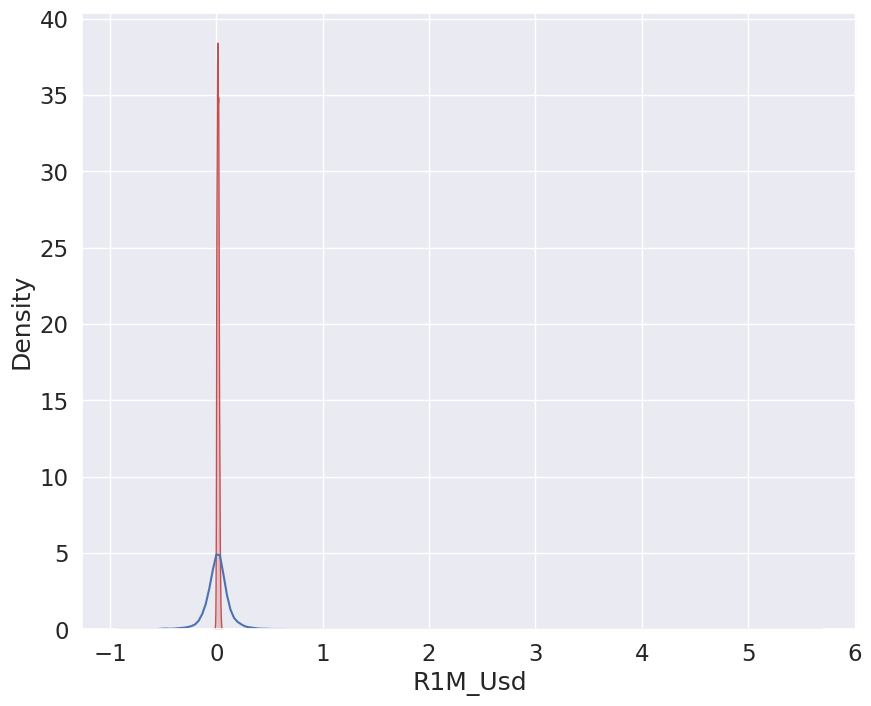

In [351]:
plt.figure(figsize=(10,8))
sns.set_style('darkgrid')
sns.kdeplot(y_train,color='b')
sns.kdeplot(ols_pred_tr,shade=True,color='r');

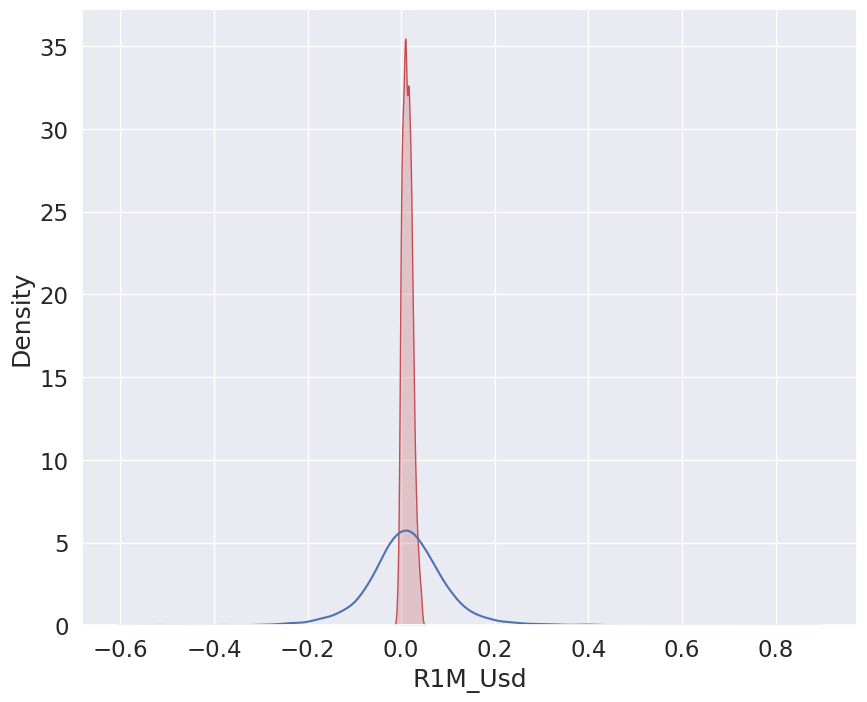

In [352]:
plt.figure(figsize=(10,8))
sns.set_style('darkgrid')
sns.kdeplot(y_test,color='b')
sns.kdeplot(ols_pred_te,shade=True,color='r');

We may compare the summary statistics for the test target variable and predicted outcme from each model.

In [353]:
from scipy import stats
[stats.describe(y_test),
 stats.describe(ols_pred_te)]

[DescribeResult(nobs=3546, minmax=(-0.555, 0.847), mean=0.012615341229554426, variance=0.007844824633409622, skewness=0.5052520133395144, kurtosis=7.91715380764944),
 DescribeResult(nobs=3546, minmax=(-0.00971868637793806, 0.04734102950821951), mean=0.013115081268952257, variance=0.00010797548781732958, skewness=0.4176405293124562, kurtosis=-0.28791086644967256)]

**Decision tree**

In [354]:
dt = DecisionTreeRegressor(max_depth=3,random_state=123)
dt.fit(X_train,y_train)

dt_pred_tr = dt.predict(X_train)
dt_pred_te = dt.predict(X_test)

pd.concat([eval_metrics('dt','train',y_train,dt_pred_tr),
           eval_metrics('dt','test',y_test,dt_pred_te)],
          ignore_index=True, axis=0)

,model,sample,rmse,mae,max_e,r2
0,dt,train,0.017,0.080,5.602,0.056
1,dt,test,0.008,0.062,0.814,0.002


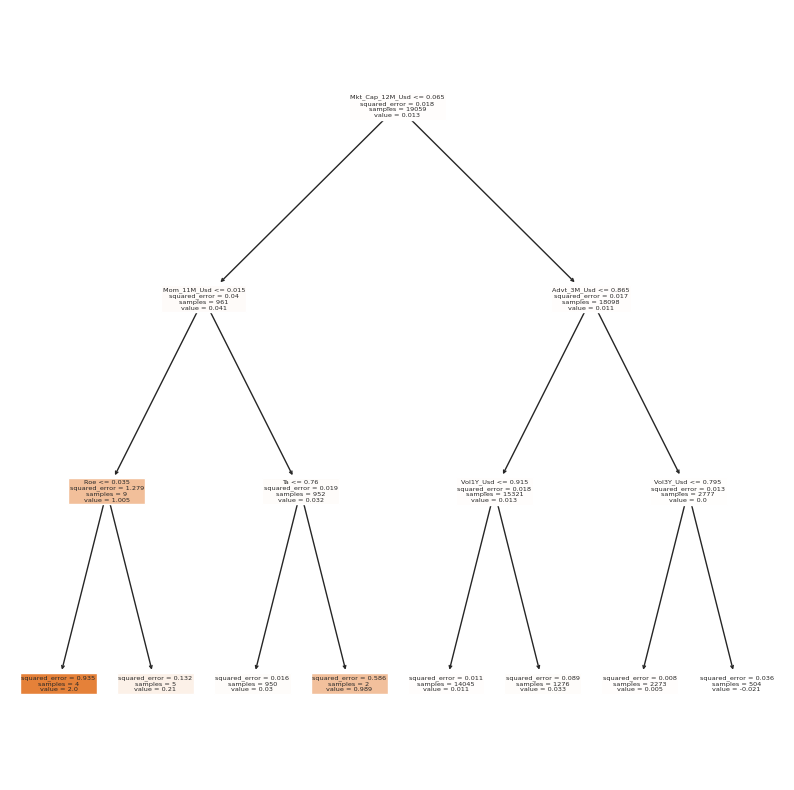

In [355]:
fig = plt.figure(figsize=(10,10))
tree.plot_tree(dt,feature_names=X_train.columns,filled=True);

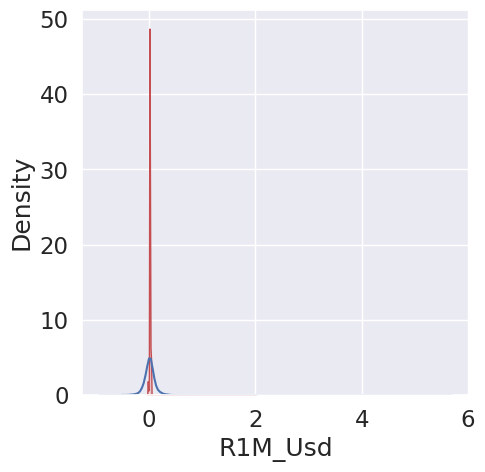

In [356]:
plt.figure(figsize=(5,5))
sns.set_style('darkgrid')
sns.kdeplot(y_train,color='b')
sns.kdeplot(dt_pred_tr,shade=True,color='r');

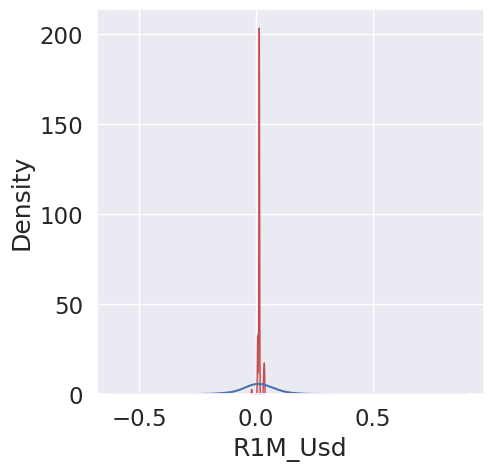

In [357]:
plt.figure(figsize=(5,5))
sns.set_style('darkgrid')
sns.kdeplot(y_test,color='b')
sns.kdeplot(dt_pred_te,shade=True,color='r');

In [358]:
from scipy import stats
[stats.describe(y_test),
 stats.describe(dt_pred_te)]

[DescribeResult(nobs=3546, minmax=(-0.555, 0.847), mean=0.012615341229554426, variance=0.007844824633409622, skewness=0.5052520133395144, kurtosis=7.91715380764944),
 DescribeResult(nobs=3546, minmax=(-0.020873015873015866, 0.033357366771159885), mean=0.012294089927478479, variance=5.9138902888445285e-05, skewness=0.7049920813801427, kurtosis=5.567918258094901)]

**Random Forest**

In [359]:
rf = RandomForestRegressor(n_estimators=200,max_depth=3,min_samples_leaf=20,random_state=123)
rf.fit(X_train,y_train)

rf_pred_tr = rf.predict(X_train)
rf_pred_te = rf.predict(X_test)

pd.concat([eval_metrics('rf','train',y_train,rf_pred_tr),
           eval_metrics('rf','test',y_test,rf_pred_te)],
          ignore_index=True, axis=0)

,model,sample,rmse,mae,max_e,r2
0,rf,train,0.018,0.080,5.546,0.029
1,rf,test,0.008,0.063,0.802,0.002


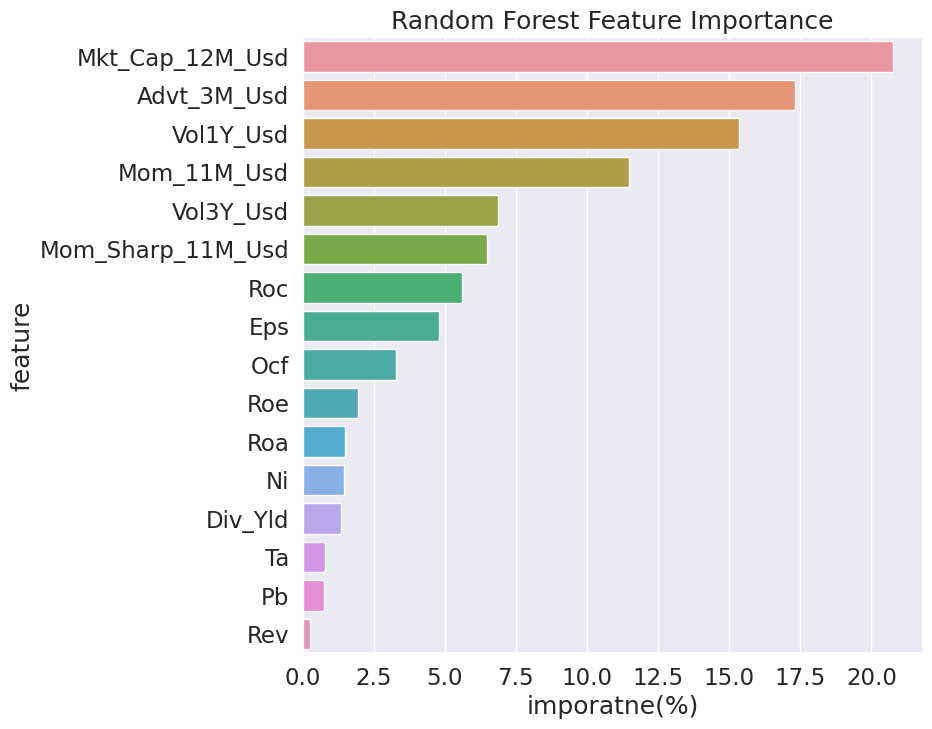

In [360]:
from sklearn.inspection import permutation_importance
result = permutation_importance(rf, X_train, y_train, n_repeats=10, random_state=123, n_jobs=2)
forest_importances = pd.DataFrame(np.abs(result.importances_mean), index=X_train.columns).reset_index()
forest_importances.columns = ['feature','importance']
forest_importances['imporatne(%)'] = np.round(100*forest_importances.importance / forest_importances.importance.sum(),2)
forest_importances =  forest_importances.sort_values(by='imporatne(%)',ascending=False)
plt.figure(figsize=(8,8))
sns.barplot(data=forest_importances, y='feature',x='imporatne(%)').set(title='Random Forest Feature Importance');

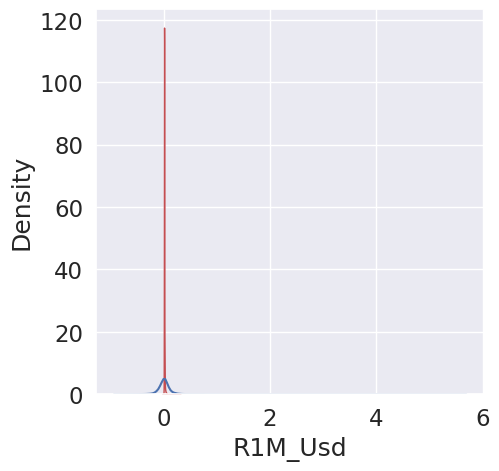

In [361]:
plt.figure(figsize=(5,5))
sns.set_style('darkgrid')
sns.kdeplot(y_train,color='b')
sns.kdeplot(rf_pred_tr,shade=True,color='r');

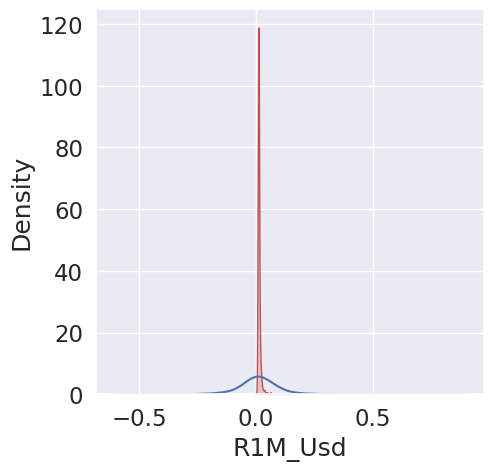

In [362]:
plt.figure(figsize=(5,5))
sns.set_style('darkgrid')
sns.kdeplot(y_test,color='b')
sns.kdeplot(rf_pred_te,shade=True,color='r');

In [363]:
from scipy import stats
[stats.describe(y_test),
 stats.describe(rf_pred_te)]

[DescribeResult(nobs=3546, minmax=(-0.555, 0.847), mean=0.012615341229554426, variance=0.007844824633409622, skewness=0.5052520133395144, kurtosis=7.91715380764944),
 DescribeResult(nobs=3546, minmax=(-0.0034705596026717057, 0.1481954338169155), mean=0.01263502047868183, variance=7.003414631002365e-05, skewness=7.288817334277006, kurtosis=79.75183661320662)]

**Neural Net**

In [364]:
from sklearn.neural_network import MLPRegressor

nnet = MLPRegressor(hidden_layer_sizes=(20,50,10), activation='relu',alpha=0.2, random_state=124)

nnet.fit(X_train,y_train)

nnet_pred_tr = nnet.predict(X_train)
nnet_pred_te = nnet.predict(X_test)

pd.concat([eval_metrics('nnet','train',y_train,nnet_pred_tr),
           eval_metrics('nnet','test',y_test,nnet_pred_te)],
          ignore_index=True, axis=0)

,model,sample,rmse,mae,max_e,r2
0,nnet,train,0.018,0.080,5.609,-0.003
1,nnet,test,0.008,0.063,0.820,-0.013


**Ensemble**

In [365]:
#stacking ensemble
from sklearn.linear_model import LassoCV, Ridge

estimators = [
    ('ols', ols),
    ('dt',dt),
    ('rf',rf),
    ('nnet',nnet)

]

ens = StackingRegressor(
    estimators=estimators,
    final_estimator = LinearRegression()
    #final_estimator = MLPRegressor(hidden_layer_sizes=(15,20,15), activation='relu')
)

ens.fit(X_train, y_train)


StackingRegressor(estimators=[('ols', LinearRegression()),
                              ('dt',
                               DecisionTreeRegressor(max_depth=3,
                                                     random_state=123)),
                              ('rf',
                               RandomForestRegressor(max_depth=3,
                                                     min_samples_leaf=20,
                                                     n_estimators=200,
                                                     random_state=123)),
                              ('nnet',
                               MLPRegressor(alpha=0.2,
                                            hidden_layer_sizes=(20, 50, 10),
                                            random_state=124))],
                  final_estimator=LinearRegression())

In [366]:
ens_pred_tr = ens.predict(X_train)
ens_pred_te = ens.predict(X_test)

pd.concat([eval_metrics('ols','train',y_train,ens_pred_tr),
           eval_metrics('ols','test',y_test,ens_pred_te)],
          ignore_index=True, axis=0)

,model,sample,rmse,mae,max_e,r2
0,ols,train,0.018,0.080,5.584,0.024
1,ols,test,0.008,0.063,0.803,0.002


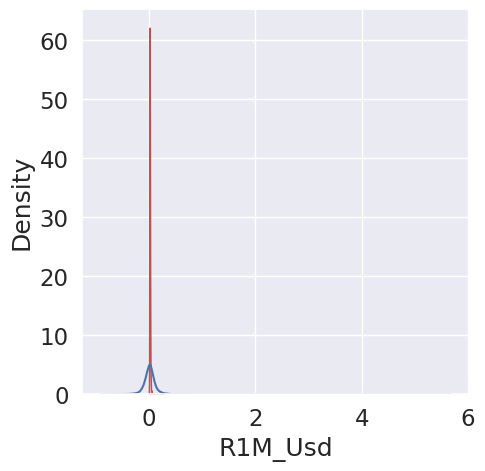

In [367]:
plt.figure(figsize=(5,5))
sns.set_style('darkgrid')
sns.kdeplot(y_train,color='b')
sns.kdeplot(ens_pred_tr,shade=True,color='r');

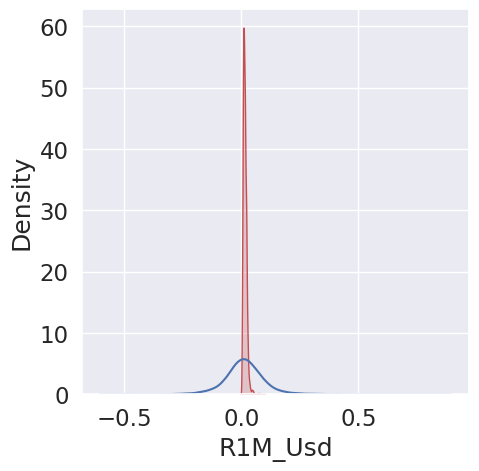

In [368]:
plt.figure(figsize=(5,5))
sns.set_style('darkgrid')
sns.kdeplot(y_test,color='b')
sns.kdeplot(ens_pred_te,shade=True,color='r');

# Part II: Portfolio construction and Risk-Adjusted Return

At this point, we may implement a buy and hold strategy based on the highest predicted returns. One way to do this is by selecting top/bottom percentile p of predicted returns by the models and taking a buy/sell position on them.

In [369]:
df_tr_preds = df_train
df_tr_preds['ols_preds'] = ols_pred_tr
df_tr_preds['dt_preds'] = dt_pred_tr
df_tr_preds['rf_preds'] = rf_pred_tr
df_tr_preds['nnet_preds'] = nnet_pred_tr
df_tr_preds['ens_preds'] = ens_pred_tr

In [370]:
df_te_preds = df_test
df_te_preds['ols_preds'] = ols_pred_te
df_te_preds['dt_preds'] = dt_pred_te
df_te_preds['rf_preds'] = rf_pred_te
df_te_preds['nnet_preds'] = nnet_pred_te
df_te_preds['ens_preds'] = ens_pred_te

In [371]:
df_all_preds = pd.concat([df_tr_preds, df_te_preds], axis=0).join(df[['stock_id','date']],how='inner')

In [372]:
returns_pivot = df_all_preds.pivot(index='date', columns='stock_id', values='R1M_Usd').dropna(axis='columns')

**Implementing Strategies**

**OLS**

In [373]:
############# Dropping stokcs without full history, forming percent rank ordering of predicted returns
ols_preds_pivot = df_all_preds.pivot(index='date', columns='stock_id', values='ols_preds').dropna(axis='columns')
ols_preds_pivot_pos = np.sign(ols_preds_pivot)*ols_preds_pivot
ols_preds_pivot_pct_ranked = ols_preds_pivot_pos.rank(pct=True)

############# Selecting stocks which their predicted returns fall above bound value percent rank
weight = 1/ols_preds_pivot_pct_ranked.sum(axis=1) #this gives equal weights to the selected stocks
ols_preds_pivot_pct_ranked.mask( ols_preds_pivot_pct_ranked >= bound,1, inplace=True)
ols_preds_pivot_pct_ranked.mask( ols_preds_pivot_pct_ranked < bound,0,inplace=True)
ols_preds_pivot_pct_ranked_signal = ols_preds_pivot_pct_ranked.mul(weight, axis=0)

############# Creating signal
ols_ret_mul_signal = returns_pivot*ols_preds_pivot_pct_ranked_signal.shift(1)
ols_strat_retuns = pd.DataFrame(ols_ret_mul_signal.sum(axis=1)).rename(columns={0: "ols_strat"})
ols_strat_retuns['ols_strat_cum'] = ols_strat_retuns['ols_strat'].cumsum()

In [412]:
ols_ret_mul_signal

stock_id,1,3,4,7,9,11,12,16,17,18,...,81,84,85,87,89,90,91,92,96,100
date,,,,,,,,,,,,,,,,,,,,,
2000-01-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-02-29,0.007844,-0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.005875,-0.001581,-0.000030,...,0.000000,-0.002774,0.000805,0.0,0.000000,0.000000,-0.0,0.000000,0.000000,0.000000
2000-03-31,0.000904,0.000000,0.000000,0.000000,-0.000000,0.000000,0.000000,-0.000875,0.002158,-0.000058,...,0.000000,0.002829,0.000000,-0.0,0.000000,0.000000,-0.0,0.000000,0.000000,-0.000000
2000-04-30,0.012706,0.000000,-0.000000,-0.000000,-0.000624,0.000000,0.000000,0.004566,0.000000,-0.001049,...,0.000000,0.002411,0.000908,0.0,-0.000000,-0.000284,-0.0,0.000000,-0.000000,0.000000
2000-05-31,-0.002832,0.000000,0.000000,0.000000,-0.003533,-0.000000,-0.000000,-0.000584,0.000000,-0.003825,...,0.000000,-0.001255,-0.002161,0.0,-0.000000,-0.001401,0.0,0.000000,-0.005839,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-31,-0.000000,-0.001371,0.001008,-0.001903,-0.000000,0.004086,0.001120,0.000000,0.008313,0.000700,...,-0.000392,-0.000672,-0.000000,0.0,-0.000392,-0.000084,-0.0,-0.000952,0.000000,0.003303
2018-09-30,-0.000000,-0.001963,-0.000701,-0.001458,-0.000000,-0.008162,-0.001234,-0.000000,-0.000000,-0.003786,...,-0.001683,-0.000084,-0.000000,-0.0,-0.002608,0.001094,-0.0,-0.002693,-0.000000,-0.001907
2018-10-31,0.000000,0.001034,0.000000,0.000201,-0.000000,-0.002872,0.002125,0.000000,-0.000000,0.002125,...,0.000919,0.003447,0.000000,0.0,0.002327,-0.000144,0.0,-0.000373,0.000000,0.002384


**DT**

In [374]:
############# Dropping stokcs without full history, forming percent rank ordering of predicted returns
dt_preds_pivot = df_all_preds.pivot(index='date', columns='stock_id', values='dt_preds').dropna(axis='columns')
dt_preds_pivot_pos = np.sign(dt_preds_pivot)*dt_preds_pivot
dt_preds_pivot_pct_ranked = dt_preds_pivot_pos.rank(pct=True)

############# Selecting stocks which their predicted returns fall above bound value percent rank
weight = 1/dt_preds_pivot_pct_ranked.sum(axis=1) #this gives equal weights to the selected stocks
dt_preds_pivot_pct_ranked.mask( dt_preds_pivot_pct_ranked >= bound,1, inplace=True)
dt_preds_pivot_pct_ranked.mask( dt_preds_pivot_pct_ranked < bound,0,inplace=True)
dt_preds_pivot_pct_ranked_signal = dt_preds_pivot_pct_ranked.mul(weight, axis=0)

############# Creating signal
dt_ret_mul_signal = returns_pivot*dt_preds_pivot_pct_ranked_signal.shift(1)
dt_strat_retuns = pd.DataFrame(dt_ret_mul_signal.sum(axis=1)).rename(columns={0: "dt_strat"})
dt_strat_retuns['dt_strat_cum'] = dt_strat_retuns['dt_strat'].cumsum()

**RF**

In [375]:
############# Dropping stokcs without full history, forming percent rank ordering of predicted returns
rf_preds_pivot = df_all_preds.pivot(index='date', columns='stock_id', values='rf_preds').dropna(axis='columns')
rf_preds_pivot_pos = np.sign(rf_preds_pivot)*rf_preds_pivot
rf_preds_pivot_pct_ranked = rf_preds_pivot_pos.rank(pct=True)

############# Selecting stocks which their predicted returns fall above bound value percent rank
weight = 1/rf_preds_pivot_pct_ranked.sum(axis=1) #this gives equal weights to the selected stocks
rf_preds_pivot_pct_ranked.mask( rf_preds_pivot_pct_ranked >= bound,1, inplace=True)
rf_preds_pivot_pct_ranked.mask( rf_preds_pivot_pct_ranked < bound,0,inplace=True)
rf_preds_pivot_pct_ranked_signal = rf_preds_pivot_pct_ranked.mul(weight, axis=0)

############# Creating signal
rf_ret_mul_signal = returns_pivot*rf_preds_pivot_pct_ranked_signal.shift(1)
rf_strat_retuns = pd.DataFrame(rf_ret_mul_signal.sum(axis=1)).rename(columns={0: "rf_strat"})
rf_strat_retuns['rf_strat_cum'] = rf_strat_retuns['rf_strat'].cumsum()

**NNET**

In [376]:
############# Dropping stokcs without full history, forming percent rank ordering of predicted returns
nnet_preds_pivot = df_all_preds.pivot(index='date', columns='stock_id', values='nnet_preds').dropna(axis='columns')
nnet_preds_pivot_pos = np.sign(nnet_preds_pivot)*nnet_preds_pivot
nnet_preds_pivot_pct_ranked = nnet_preds_pivot_pos.rank(pct=True)

############# Selecting stocks which their predicted returns fall above bound value percent rank
weight = 1/nnet_preds_pivot_pct_ranked.sum(axis=1) #this gives equal weights to the selected stocks
nnet_preds_pivot_pct_ranked.mask( nnet_preds_pivot_pct_ranked >= bound,1, inplace=True)
nnet_preds_pivot_pct_ranked.mask( nnet_preds_pivot_pct_ranked < bound,0,inplace=True)
nnet_preds_pivot_pct_ranked_signal = nnet_preds_pivot_pct_ranked.mul(weight, axis=0)

############# Creating signal
nnet_ret_mul_signal = returns_pivot*nnet_preds_pivot_pct_ranked_signal.shift(1)
nnet_strat_retuns = pd.DataFrame(nnet_ret_mul_signal.sum(axis=1)).rename(columns={0: "nnet_strat"})
nnet_strat_retuns['nnet_strat_cum'] = nnet_strat_retuns['nnet_strat'].cumsum()

**Benchmark**

In [377]:
############# Dropping stokcs without full history, forming percent rank ordering of predicted returns
benchmark_preds_pivot = df_all_preds.pivot(index='date', columns='stock_id', values='R1M_Usd').dropna(axis='columns')
benchmark_preds_pivot_pos = np.sign(benchmark_preds_pivot)*benchmark_preds_pivot
benchmark_preds_pivot_pct_ranked = benchmark_preds_pivot_pos.rank(pct=True)

############# Selecting stocks which their predicted returns fall above bound value percent rank
weight = 1/benchmark_preds_pivot_pct_ranked.sum(axis=1) #this gives equal weights to the selected stocks
benchmark_preds_pivot_pct_ranked.mask( benchmark_preds_pivot_pct_ranked >= bound,1, inplace=True)
benchmark_preds_pivot_pct_ranked.mask( benchmark_preds_pivot_pct_ranked < bound,0,inplace=True)
benchmark_preds_pivot_pct_ranked_signal = benchmark_preds_pivot_pct_ranked.mul(weight, axis=0)

############# Creating signal
benchmark_ret_mul_signal = returns_pivot*benchmark_preds_pivot_pct_ranked_signal.shift(1)
benchmark_strat_retuns = pd.DataFrame(benchmark_ret_mul_signal.sum(axis=1)).rename(columns={0: "benchmark_strat"})
benchmark_strat_retuns['benchmark_strat_cum'] = benchmark_strat_retuns['benchmark_strat'].cumsum()

**Ensemble:**

In [378]:
############# Dropping stokcs without full history, forming percent rank ordering of predicted returns
ens_preds_pivot = df_all_preds.pivot(index='date', columns='stock_id', values='ens_preds').dropna(axis='columns')
ens_preds_pivot_pos = np.sign(ens_preds_pivot)*ens_preds_pivot
ens_preds_pivot_pct_ranked = ens_preds_pivot_pos.rank(pct=True)

############# Selecting stocks which their predicted returns fall above bound value percent rank
weight = 1/ens_preds_pivot_pct_ranked.sum(axis=1) #this gives equal weights to the selected stocks
ens_preds_pivot_pct_ranked.mask( ens_preds_pivot_pct_ranked >= bound,1, inplace=True)
ens_preds_pivot_pct_ranked.mask( ens_preds_pivot_pct_ranked < bound,0,inplace=True)
ens_preds_pivot_pct_ranked_signal = ens_preds_pivot_pct_ranked.mul(weight, axis=0)

############# Creating signal
ens_ret_mul_signal = returns_pivot*ens_preds_pivot_pct_ranked_signal.shift(1)
ens_strat_retuns = pd.DataFrame(ens_ret_mul_signal.sum(axis=1)).rename(columns={0: "ens_strat"})
ens_strat_retuns['ens_strat_cum'] = ens_strat_retuns['ens_strat'].cumsum()

In [421]:
############# Dropping stokcs without full history, forming percent rank ordering of predicted returns
all_preds_pivot = df_all_preds.pivot(index='date', columns='stock_id', values='R1M_Usd').dropna(axis='columns')
all_preds_pivot_pos = np.sign(all_preds_pivot)*all_preds_pivot
all_preds_pivot_pct_ranked = all_preds_pivot_pos.rank(pct=True)

############# Selecting stocks which their predicted returns fall above bound value percent rank
weight = 1/all_preds_pivot_pct_ranked.sum(axis=1) #this gives equal weights to the selected stocks
all_preds_pivot_pct_ranked.mask( all_preds_pivot_pct_ranked >= 1, 1, inplace=True)
all_preds_pivot_pct_ranked.mask( all_preds_pivot_pct_ranked < 0,0,inplace=True)
all_preds_pivot_pct_ranked_signal = all_preds_pivot_pct_ranked.mul(weight, axis=0)

############# Creating signal
all_ret_mul_signal = returns_pivot*all_preds_pivot_pct_ranked_signal.shift(1)
all_strat_retuns = pd.DataFrame(all_ret_mul_signal.sum(axis=1)).rename(columns={0: "all_strat"})
all_strat_retuns['all_strat_cum'] = all_strat_retuns['all_strat'].cumsum()

In [422]:
all_strat_retuns

,all_strat,all_strat_cum
date,,
2000-01-31,0.000000,0.000000
2000-02-29,0.045427,0.045427
2000-03-31,0.001744,0.047171
2000-04-30,0.000240,0.047411
2000-05-31,0.042285,0.089697
...,...,...
2018-08-31,-0.000342,2.810132
2018-09-30,-0.088279,2.721852
2018-10-31,0.017807,2.739660


**Evaluation and comparison**

In [423]:
all_strats_returns = benchmark_strat_retuns.join(ols_strat_retuns, on='date').join(dt_strat_retuns, on='date').join(rf_strat_retuns,on='date').join(nnet_strat_retuns,on='date').join(ens_strat_retuns,on='date').join(all_strat_retuns, on='date').reset_index()
all_strats_returns_melt = all_strats_returns.melt(id_vars='date',var_name='strategy',value_name='cum_return')
all_strats_returns_melt_cum = all_strats_returns_melt[all_strats_returns_melt['strategy'].str.contains("cum", case=False)]
all_strats_returns_melt_cum['strategy'] = all_strats_returns_melt_cum['strategy'].str.replace('_strat_cum', '', regex=True)

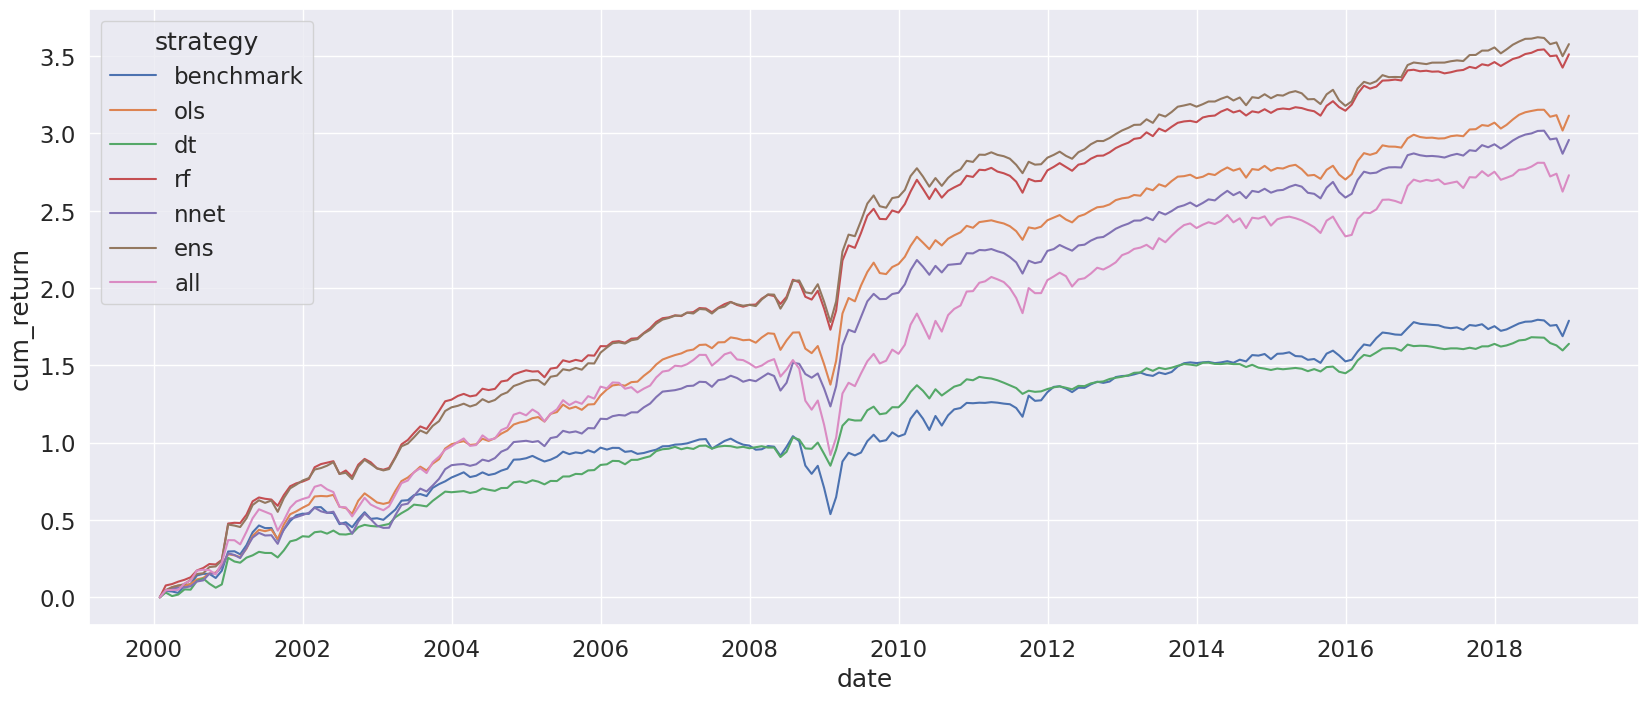

In [424]:
plt.figure(figsize=(20,8))
sns.set_style('darkgrid')
sns.lineplot(data=all_strats_returns_melt_cum,x='date',y='cum_return',hue='strategy');

 We may define a combined metric to evaluate strategy performances:

In [381]:
def strat_perf(x):
  vol = np.round(np.std(x)*np.sqrt(12),3)
  mret = np.round(np.mean(x),3)*12
  Ratio = np.round(mret/vol,3)
  cum_ret = np.round(np.max(x.cumsum()),3)
  df_perf = pd.DataFrame({'Strategy':x.name.replace('_strat','').upper(),'Mean_Return':[mret],'Volatility':[vol],'Risk_Return_Ratio':[Ratio],'Cumulative_Return':[cum_ret]})
  return df_perf

# All Strategies' Risk-Return Overview

In [387]:
all_strats = strat_perf(benchmark_strat_retuns.benchmark_strat).append(strat_perf(ols_strat_retuns.ols_strat)).append(strat_perf(dt_strat_retuns.dt_strat)).append(strat_perf(rf_strat_retuns.rf_strat)).append(strat_perf(nnet_strat_retuns.nnet_strat)).append(strat_perf(ens_strat_retuns.ens_strat))

all_strats=all_strats.set_index('Strategy')

all_strats.style.highlight_max(color = 'darkgreen')

#all_strats.style.highlight_max(color = 'lightgreen', subset=pd.IndexSlice[:, ['Volatility']])


,Mean_Return,Volatility,Risk_Return_Ratio,Cumulative_Return
Strategy,,,,
BENCHMARK,0.096000,0.142000,0.676000,1.795000
OLS,0.168000,0.148000,1.135000,3.153000
DT,0.084000,0.097000,0.866000,1.682000
RF,0.180000,0.156000,1.154000,3.544000
NNET,0.156000,0.144000,1.083000,3.018000
ENS,0.192000,0.158000,1.215000,3.622000


### **Summary**

Changing the key parameters described at the start of this notebook could result in a very different portfolio of selected stocks and hence a different return-risk profile. We will focus on making some of these changes and recording the outcome in the next assignment.